<a href="https://colab.research.google.com/github/yigitgoktas/cs484/blob/main/CS484.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the modules

In [ ]:
%pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary

import os
from glob import glob

import matplotlib.pyplot as plt
import random


# Download the dataset

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz

In [ ]:
!ls -d images/*/

images/Abyssinian/		   images/leonberger/
images/american_bulldog/	   images/Maine_Coon/
images/american_pit_bull_terrier/  images/miniature_pinscher/
images/basset_hound/		   images/newfoundland/
images/beagle/			   images/Persian/
images/Bengal/			   images/pomeranian/
images/Birman/			   images/pug/
images/Bombay/			   images/Ragdoll/
images/boxer/			   images/Russian_Blue/
images/British_Shorthair/	   images/saint_bernard/
images/chihuahua/		   images/samoyed/
images/Egyptian_Mau/		   images/scottish_terrier/
images/english_cocker_spaniel/	   images/shiba_inu/
images/english_setter/		   images/Siamese/
images/german_shorthaired/	   images/Sphynx/
images/great_pyrenees/		   images/staffordshire_bull_terrier/
images/havanese/		   images/wheaten_terrier/
images/japanese_chin/		   images/yorkshire_terrier/
images/keeshond/


In [ ]:
!rm -R images/.ipynb_checkpoints

rm: cannot remove 'images/.ipynb_checkpoints': No such file or directory


In [ ]:
import os

folder = None
for i in os.listdir("images"):
    folder = i.split('_')[:-1]
    folder = "_".join(folder)
    try:
        os.rename(f"images/{i}", f"images/{folder}/{i}")
    except:
        os.mkdir(f"images/{folder}")
        os.rename(f"images/{i}", f"images/{folder}/{i}")
        

# Load and preprocess the Oxford-IIIT Pet Dataset:

In [ ]:
input_shape = (224,224,3)
data_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(input_shape[0]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
orig_set = datasets.ImageFolder("images", data_transforms)
n = len(orig_set)  # total number of examples
indices = np.arange(n)
np.random.seed(31)
np.random.shuffle(indices)
n_test = int(0.1 * n) 
n_val = int(0.2 * n)
test_set = torch.utils.data.Subset(orig_set, indices[:n_test])  # take first 10%
val_set = torch.utils.data.Subset(orig_set, indices[n_test:n_test+n_val])  # take the rest   
train_set = torch.utils.data.Subset(orig_set, indices[n_test+n_val:])  # take the rest

In [ ]:
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 224, 224])

# Create train and validation data generators:

In [ ]:
model = models.vgg16(pretrained = True )


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 249MB/s]


# Load VGG model and add custom layers:

In [ ]:
vgg16 = model
checkpoint_dir = "drive/MyDrive"

# Replace the last layer of the classifier to match the number of classes (37)
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 37)

# Freeze the feature extraction layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Set up the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and validation loop
num_epochs = 25
best_loss = np.inf
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
    
    # Validation loop
    vgg16.eval()
    val_running_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for val_inputs, val_labels in tqdm(val_loader):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = vgg16(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, val_preds = torch.max(val_outputs, 1)
            val_corrects += torch.sum(val_preds == val_labels.data)

    scheduler.step()

    # Print the average loss and validation accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val. Loss: {val_epoch_loss:.4f}, Val. Acc: {val_epoch_acc:.4f}")
    
    # Save the model checkpoint
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': vgg16.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_loss,
            'val_loss': val_epoch_loss,
            'val_accuracy': val_epoch_acc
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint.pth'))

print("Training and validation complete.")


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


Epoch 1/25, Loss: 1.6754, Val. Loss: 0.7028, Val. Acc: 0.7936


100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch 2/25, Loss: 0.7250, Val. Loss: 0.5805, Val. Acc: 0.8302


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Epoch 3/25, Loss: 0.6189, Val. Loss: 0.5199, Val. Acc: 0.8396


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Epoch 4/25, Loss: 0.6077, Val. Loss: 0.5172, Val. Acc: 0.8322


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


Epoch 5/25, Loss: 0.5736, Val. Loss: 0.5136, Val. Acc: 0.8403


100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


Epoch 6/25, Loss: 0.5554, Val. Loss: 0.5030, Val. Acc: 0.8295


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


Epoch 7/25, Loss: 0.5284, Val. Loss: 0.4895, Val. Acc: 0.8349


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 8/25, Loss: 0.5215, Val. Loss: 0.5318, Val. Acc: 0.8444


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 9/25, Loss: 0.4798, Val. Loss: 0.4602, Val. Acc: 0.8491


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


Epoch 10/25, Loss: 0.5047, Val. Loss: 0.4564, Val. Acc: 0.8559


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Epoch 11/25, Loss: 0.4952, Val. Loss: 0.4962, Val. Acc: 0.8451


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Epoch 12/25, Loss: 0.5100, Val. Loss: 0.4708, Val. Acc: 0.8390


100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


Epoch 13/25, Loss: 0.4729, Val. Loss: 0.4866, Val. Acc: 0.8444


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 14/25, Loss: 0.5000, Val. Loss: 0.5256, Val. Acc: 0.8430


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


Epoch 15/25, Loss: 0.4929, Val. Loss: 0.4411, Val. Acc: 0.8620


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 16/25, Loss: 0.4763, Val. Loss: 0.4754, Val. Acc: 0.8505


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 17/25, Loss: 0.4817, Val. Loss: 0.4279, Val. Acc: 0.8620


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


Epoch 18/25, Loss: 0.4881, Val. Loss: 0.4655, Val. Acc: 0.8484


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


Epoch 19/25, Loss: 0.4946, Val. Loss: 0.4548, Val. Acc: 0.8457


100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch 20/25, Loss: 0.4632, Val. Loss: 0.4333, Val. Acc: 0.8559


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


Epoch 21/25, Loss: 0.4974, Val. Loss: 0.4982, Val. Acc: 0.8424


100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch 22/25, Loss: 0.4820, Val. Loss: 0.4529, Val. Acc: 0.8579


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


Epoch 23/25, Loss: 0.4709, Val. Loss: 0.5105, Val. Acc: 0.8403


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


Epoch 24/25, Loss: 0.4791, Val. Loss: 0.4741, Val. Acc: 0.8457


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]

Epoch 25/25, Loss: 0.4739, Val. Loss: 0.4746, Val. Acc: 0.8579
Training and validation complete.


# Test the model:

In [ ]:
vgg16.eval()
test_running_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for test_inputs, test_labels in tqdm(test_loader):
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        
        test_outputs = vgg16(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        test_corrects += torch.sum(test_preds == test_labels.data)
test_epoch_acc = test_corrects.double() / len(test_loader.dataset)
test_epoch_acc


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


tensor(0.8687, device='cuda:0', dtype=torch.float64)

# Test the model using the best loss checkpoint

In [ ]:
checkpoint_path = 'drive/MyDrive/checkpoint.pth'
checkpoint = torch.load(checkpoint_path)

vgg16 = models.vgg16(pretrained=False)
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 37)
vgg16.load_state_dict(checkpoint['model_state_dict'])
vgg16 = vgg16.to(device)

# Test loop
vgg16.eval()
test_running_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for test_inputs, test_labels in tqdm(test_loader):
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_logits = vgg16(test_inputs)
        test_probabilities = torch.softmax(test_logits, dim=1)
        test_loss = criterion(test_logits, test_labels)
        test_running_loss += test_loss.item()

        _, test_preds = torch.max(test_probabilities, 1)
        test_corrects += torch.sum(test_preds == test_labels.data)
test_epoch_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test accuracy: {test_epoch_acc:.4f}")


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

Test accuracy: 0.8904


# test on a specific image

In [ ]:
from PIL import Image

def predict_image(model, image_path, class_names):
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Forward the preprocessed image through the model
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = torch.softmax(logits, dim=1)

    # Find the class with the highest probability
    _, predicted_class_idx = torch.max(probabilities, 1)
    predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class, probabilities.squeeze().cpu().numpy()


leonberger: 54.73%
great_pyrenees: 19.37%
american_pit_bull_terrier: 10.04%
pug: 7.48%
wheaten_terrier: 5.58%


Image Classification Results:

Image 1: images/Ragdoll/Ragdoll_114.jpg


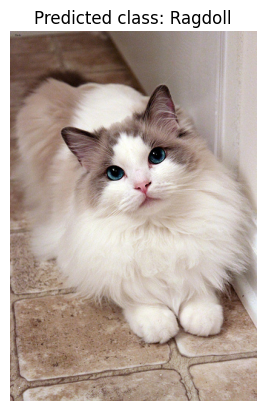

Top 3 predictions:
Ragdoll: 96.88%
Persian: 1.53%
Birman: 0.96%


Image 2: images/Bengal/Bengal_186.jpg


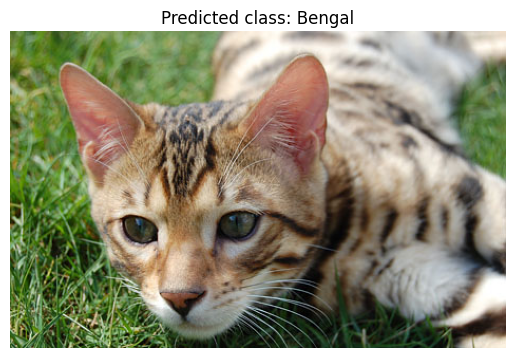

Top 3 predictions:
Bengal: 88.38%
Egyptian_Mau: 11.22%
Abyssinian: 0.25%


Image 3: images/yorkshire_terrier/yorkshire_terrier_196.jpg


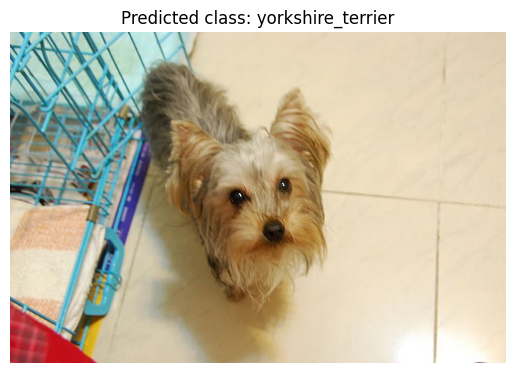

Top 3 predictions:
yorkshire_terrier: 99.92%
havanese: 0.08%
pomeranian: 0.00%


Image 4: images/leonberger/leonberger_47.jpg


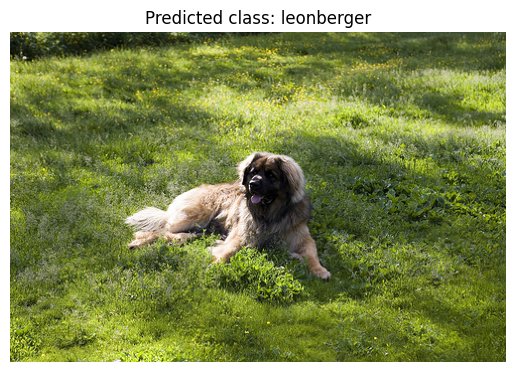

Top 3 predictions:
leonberger: 99.11%
wheaten_terrier: 0.52%
saint_bernard: 0.26%


Image 5: images/shiba_inu/shiba_inu_74.jpg


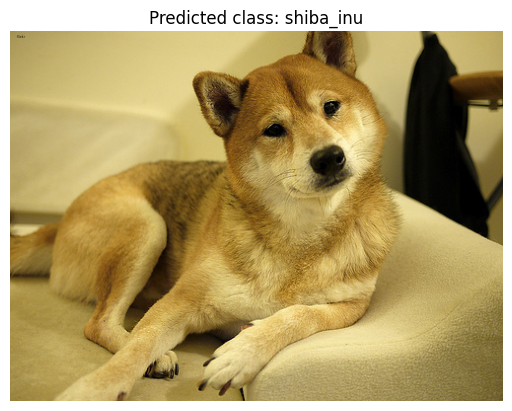

Top 3 predictions:
shiba_inu: 99.69%
Abyssinian: 0.20%
chihuahua: 0.06%


Image 6: images/samoyed/samoyed_135.jpg


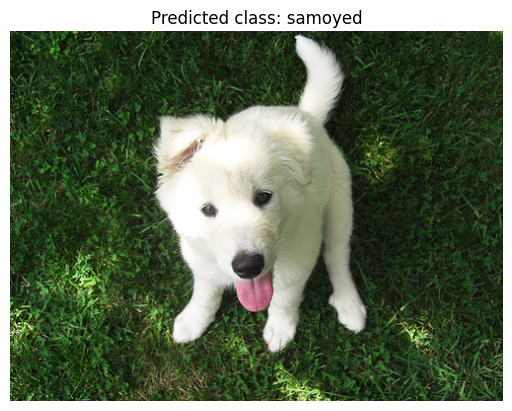

Top 3 predictions:
samoyed: 50.90%
great_pyrenees: 47.07%
saint_bernard: 0.55%


Image 7: images/japanese_chin/japanese_chin_149.jpg


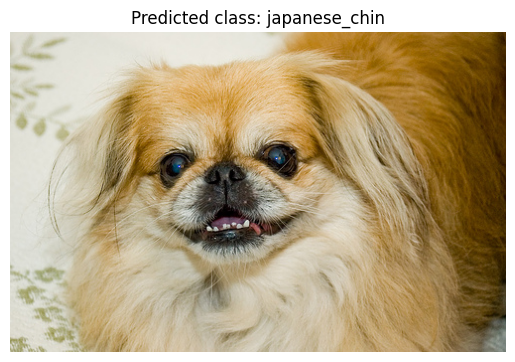

Top 3 predictions:
japanese_chin: 100.00%
pomeranian: 0.00%
pug: 0.00%


Image 8: images/great_pyrenees/great_pyrenees_185.jpg


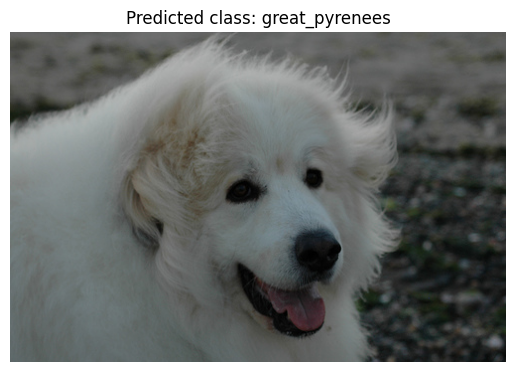

Top 3 predictions:
great_pyrenees: 96.11%
samoyed: 3.88%
saint_bernard: 0.01%


Image 9: images/havanese/havanese_100.jpg


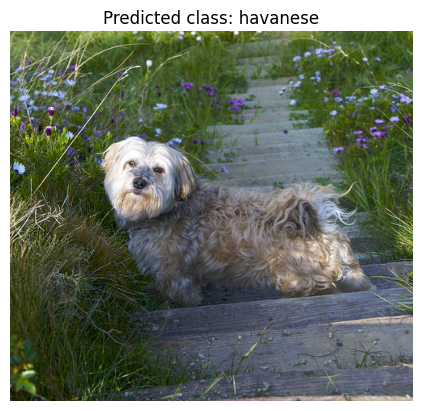

Top 3 predictions:
havanese: 74.74%
wheaten_terrier: 24.37%
yorkshire_terrier: 0.74%


Image 10: images/pomeranian/pomeranian_31.jpg


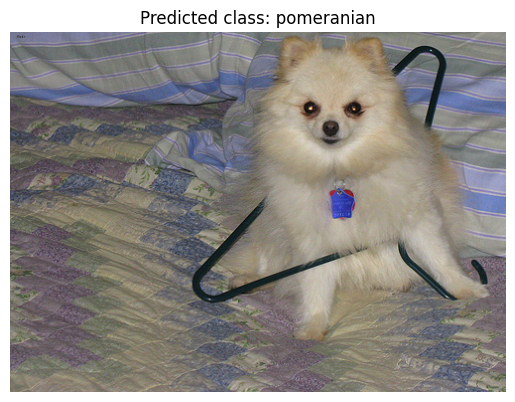

Top 3 predictions:
pomeranian: 99.77%
Birman: 0.21%
keeshond: 0.00%


Image 11: images/japanese_chin/japanese_chin_26.jpg


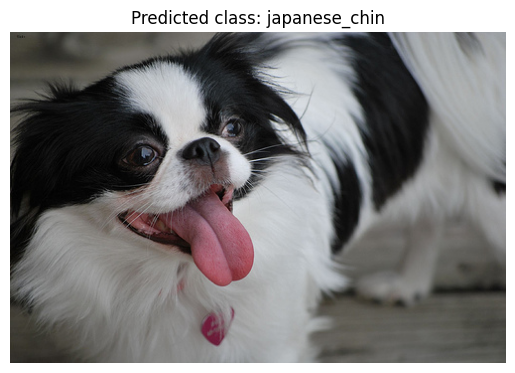

Top 3 predictions:
japanese_chin: 100.00%
pomeranian: 0.00%
Ragdoll: 0.00%


Image 12: images/Birman/Birman_177.jpg


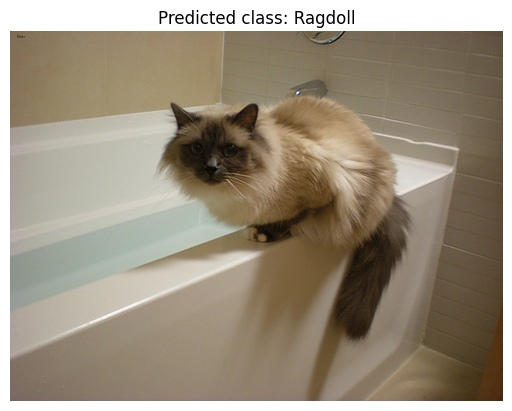

Top 3 predictions:
Ragdoll: 59.55%
Birman: 36.64%
Siamese: 3.39%


Image 13: images/staffordshire_bull_terrier/staffordshire_bull_terrier_162.jpg


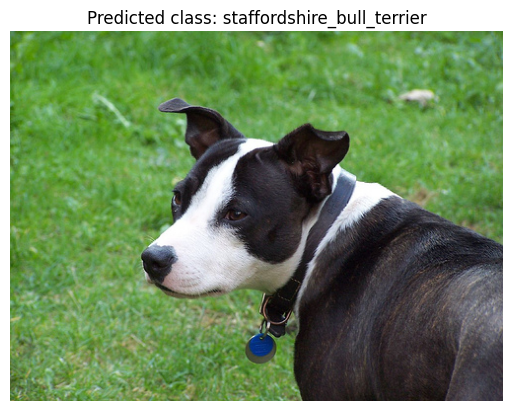

Top 3 predictions:
staffordshire_bull_terrier: 99.01%
american_pit_bull_terrier: 0.83%
american_bulldog: 0.15%


Image 14: images/boxer/boxer_179.jpg


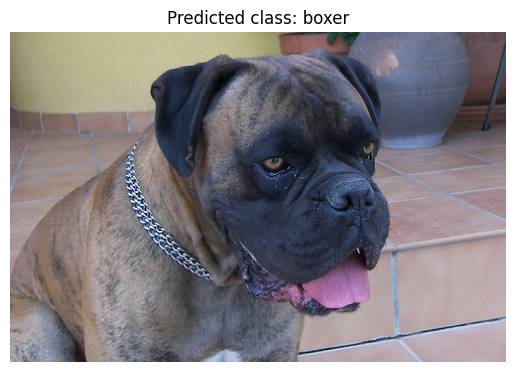

Top 3 predictions:
boxer: 99.18%
american_bulldog: 0.54%
pug: 0.22%


Image 15: images/german_shorthaired/german_shorthaired_55.jpg


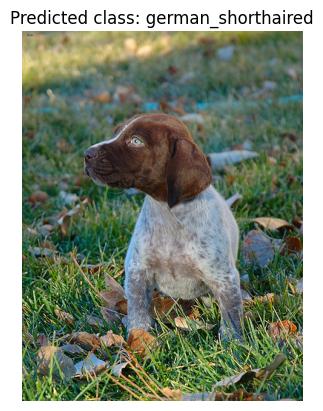

Top 3 predictions:
german_shorthaired: 99.38%
american_pit_bull_terrier: 0.39%
beagle: 0.09%


Image 16: images/samoyed/samoyed_101.jpg


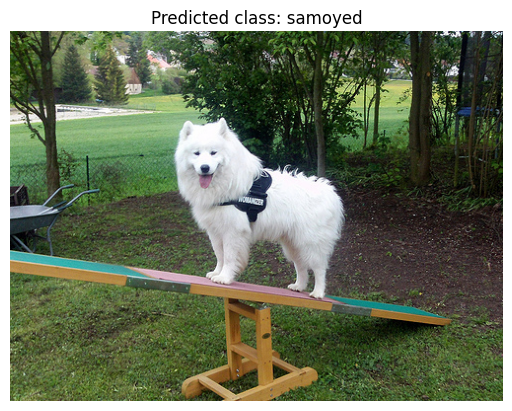

Top 3 predictions:
samoyed: 99.96%
pomeranian: 0.03%
great_pyrenees: 0.01%


Image 17: images/basset_hound/basset_hound_109.jpg


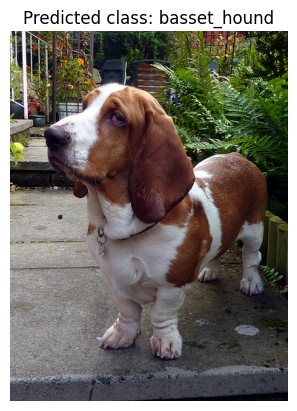

Top 3 predictions:
basset_hound: 99.94%
beagle: 0.06%
saint_bernard: 0.00%


Image 18: images/wheaten_terrier/wheaten_terrier_191.jpg


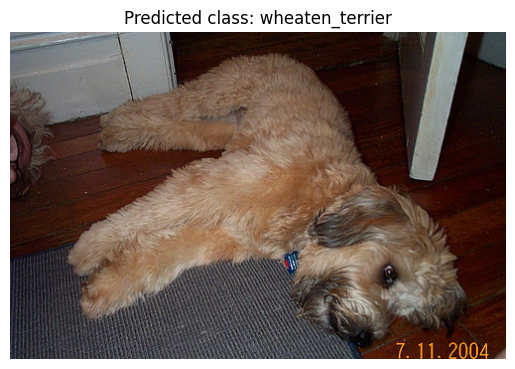

Top 3 predictions:
wheaten_terrier: 99.95%
havanese: 0.02%
english_cocker_spaniel: 0.01%


Image 19: images/Abyssinian/Abyssinian_181.jpg


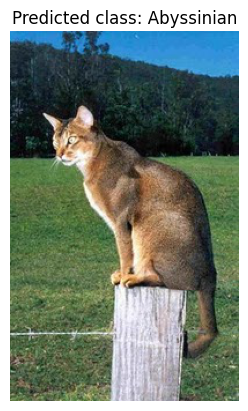

Top 3 predictions:
Abyssinian: 97.69%
shiba_inu: 1.13%
Bengal: 0.54%


Image 20: images/Ragdoll/Ragdoll_208.jpg


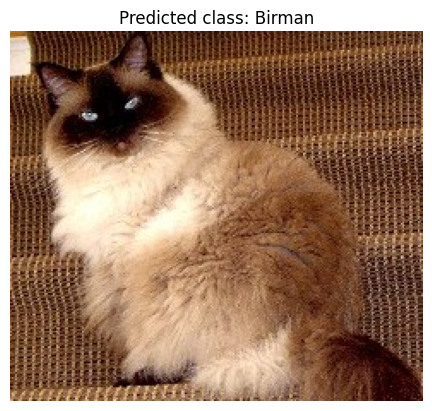

Top 3 predictions:
Birman: 63.99%
Persian: 26.47%
Ragdoll: 5.43%




In [ ]:
def display_image(image_path, title):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extract all file paths from the original dataset
all_file_paths = [x[0] for x in orig_set.imgs]

# Get the indices of the test dataset as a list
test_indices = list(test_set.indices)

# Select 10 random indices from the test dataset
num_random_images = 20
random_test_indices = random.sample(test_indices, num_random_images)

# Get the file paths of the randomly selected images
random_image_paths = [all_file_paths[idx] for idx in random_test_indices]

image_paths = []
for i, image_path in enumerate(random_image_paths, start=1):
    image_paths.append(image_path)
print("Image Classification Results:\n")

class_names = orig_set.classes

for i, image_path in enumerate(image_paths, start=1):
    predicted_class, class_probabilities = predict_image(vgg16, image_path, class_names)
    
    # Print the predicted class and show the image
    print(f"Image {i}: {image_path}")
    display_image(image_path, f"Predicted class: {predicted_class}")

    # Show the top 3 class probabilities
    top_k = 3
    sorted_indices = np.argsort(class_probabilities)[-top_k:][::-1]
    sorted_probs = class_probabilities[sorted_indices] * 100
    sorted_class_names = [class_names[i] for i in sorted_indices]

    print("Top 3 predictions:")
    for j in range(top_k):
        print(f"{sorted_class_names[j]}: {sorted_probs[j]:.2f}%")
    
    print("\n")

In [ ]:
image_paths

['images/boxer/boxer_199.jpg',
 'images/Abyssinian/Abyssinian_99.jpg',
 'images/american_pit_bull_terrier/american_pit_bull_terrier_165.jpg',
 'images/english_cocker_spaniel/english_cocker_spaniel_28.jpg',
 'images/beagle/beagle_95.jpg',
 'images/newfoundland/newfoundland_39.jpg',
 'images/saint_bernard/saint_bernard_21.jpg',
 'images/american_bulldog/american_bulldog_102.jpg',
 'images/Bengal/Bengal_68.jpg',
 'images/Maine_Coon/Maine_Coon_253.jpg']